In [1]:
import random
import re

import pandas as pd
import pytorch_lightning as pl

from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from freestyl.dataset.dataframe_wrapper import DataframeWrapper
from freestyl.supervised.siamese import train_dataframewrappers, get_df_prediction
from freestyl.supervised.siamese.utils import score_from_preds, find_index_of_first_change
from freestyl.supervised.siamese.features.model import SiameseFeatureModule
from freestyl.utils import plot_aucroc_curve
#>>> x = [1, 2, 3, 4, 5, 6]
#>>> .shuffle(x)

NEW_DATASET = False
SPLIT_ON_AUTHORS = False
USE_POS = True
USE_TRIG = True
USE_FW = True
LR = 1e-4
BATCH = 64
DROPOUT = .3
LOSS = "stn_contrastive"
CHRYSOSTOM = False
SAMPLE = True
DYDIMUS = True
COMMENT = False
DEV_MINER = True
SPLIT = False
ISDIST = "linear" not in LOSS
METRICKEY = "Probability" if not ISDIST else "Distance"

if SPLIT:
    SIZE = (32, 32, 32)
elif USE_POS and not USE_FW:
    SIZE = 50
elif USE_POS and USE_FW:
    SIZE = 64
else:
    SIZE = 64
    
seed = 42
REMOVED = ["Euclides"]


def make_file_name(filename: str) -> str:
    return filename

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in 

## Import Data

In [2]:
def get_train_dev_test(filtre, seed=42, ratio=10):
    test = len(filtre) * ratio // 100
    dev_and_test = test * 2
    print(f"Train categorical samples: {len(filtre)-dev_and_test}")
    print(f"Dev   categorical samples: {dev_and_test-test}")
    print(f"Test  categorical samples: {test}")
    r = random.Random(seed)
    r.shuffle(filtre)
    return filtre[:-dev_and_test], filtre[-dev_and_test:-test], filtre[-test:]


if NEW_DATASET:
    df = pd.read_csv("tlg-features.csv").sample(frac=1)
    #df = df[df.tokens >= 5000]
    #print(">= 5000", df.shape)
    #df = df[~df.file.isin(POETRY)]
    #print(">= Poetry", df.shape)
    # df = df[~df.title.str.contains("Dub\.|Sp\.|Fragm|Excerpt|(e cod\.)|Suda|recensio|fragm|sp\.|dub\.|(fort\. auctore)|Scholia")]
    print("Title filter", df.shape)
    #df = df[~df["full-pos-text"].isna()]
    #print(">= POS missing", df.shape)
    
    # Filter based on authors, to generalize better. Everything should be out of domain\
    train, dev, test = [], [], []
    if SPLIT_ON_AUTHORS:
        authors = df.author.value_counts()
        a, b, c = get_train_dev_test(authors[authors > 1].index.tolist())
    else:
        a, b, c = get_train_dev_test(df.title.unique().tolist())
        
    train.extend(a)
    dev.extend(b)
    test.extend(c)
    
#     a, b, c = get_train_dev_test(authors[authors == 1].index.tolist())
#     train.extend(a)
#     dev.extend(b)
#     test.extend(c)

    if SPLIT_ON_AUTHORS:
        train = df[df.author.isin(train)].copy(deep=True)
        dev = df[df.author.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.author.isin(test)].copy(deep=True)#.author.value_counts()
    else:
        train = df[df.title.isin(train)].copy(deep=True)
        dev = df[df.title.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.title.isin(test)].copy(deep=True)#.author.value_counts()
        
    train.to_csv("tlg-train.csv", index=False)
    dev.to_csv("tlg-dev.csv", index=False)
    test.to_csv("tlg-test.csv", index=False)
else:
    train = pd.read_csv("tlg-train.csv")
    dev = pd.read_csv("tlg-dev.csv")
    test = pd.read_csv("tlg-test.csv")
    
train = train[~train.author.isin(REMOVED)]
dev = dev[~dev.author.isin(REMOVED)]
test = test[~test.author.isin(REMOVED)]

if not CHRYSOSTOM:
    train = train[~train.author.str.contains("Chrysosto")]
    dev = dev[~dev.author.str.contains("Chrysosto")]
    test = test[~test.author.str.contains("Chrysosto")]
    
if not DYDIMUS:
    train = train[~train.author.str.contains("Didym")]
    dev = dev[~dev.author.str.contains("Didym")]
    test = test[~test.author.str.contains("Didym")]
    
if not COMMENT:
    train = train[~train.title.str.contains("Comment")]
    dev = dev[~dev.title.str.contains("Comment")]
    test = test[~test.title.str.contains("Comment")]

print(f"Train Shape : {train.shape}")
print(f"Dev Shape : {dev.shape}")
print(f"Test Shape : {test.shape}")

Train Shape : (1266, 2108)
Dev Shape : (141, 2108)
Test Shape : (158, 2107)


In [3]:
train.title.str.contains("Comment").value_counts()
test.title.str.contains("Comment").value_counts()

False    158
Name: title, dtype: int64

In [4]:
train.title.unique().shape

(383,)

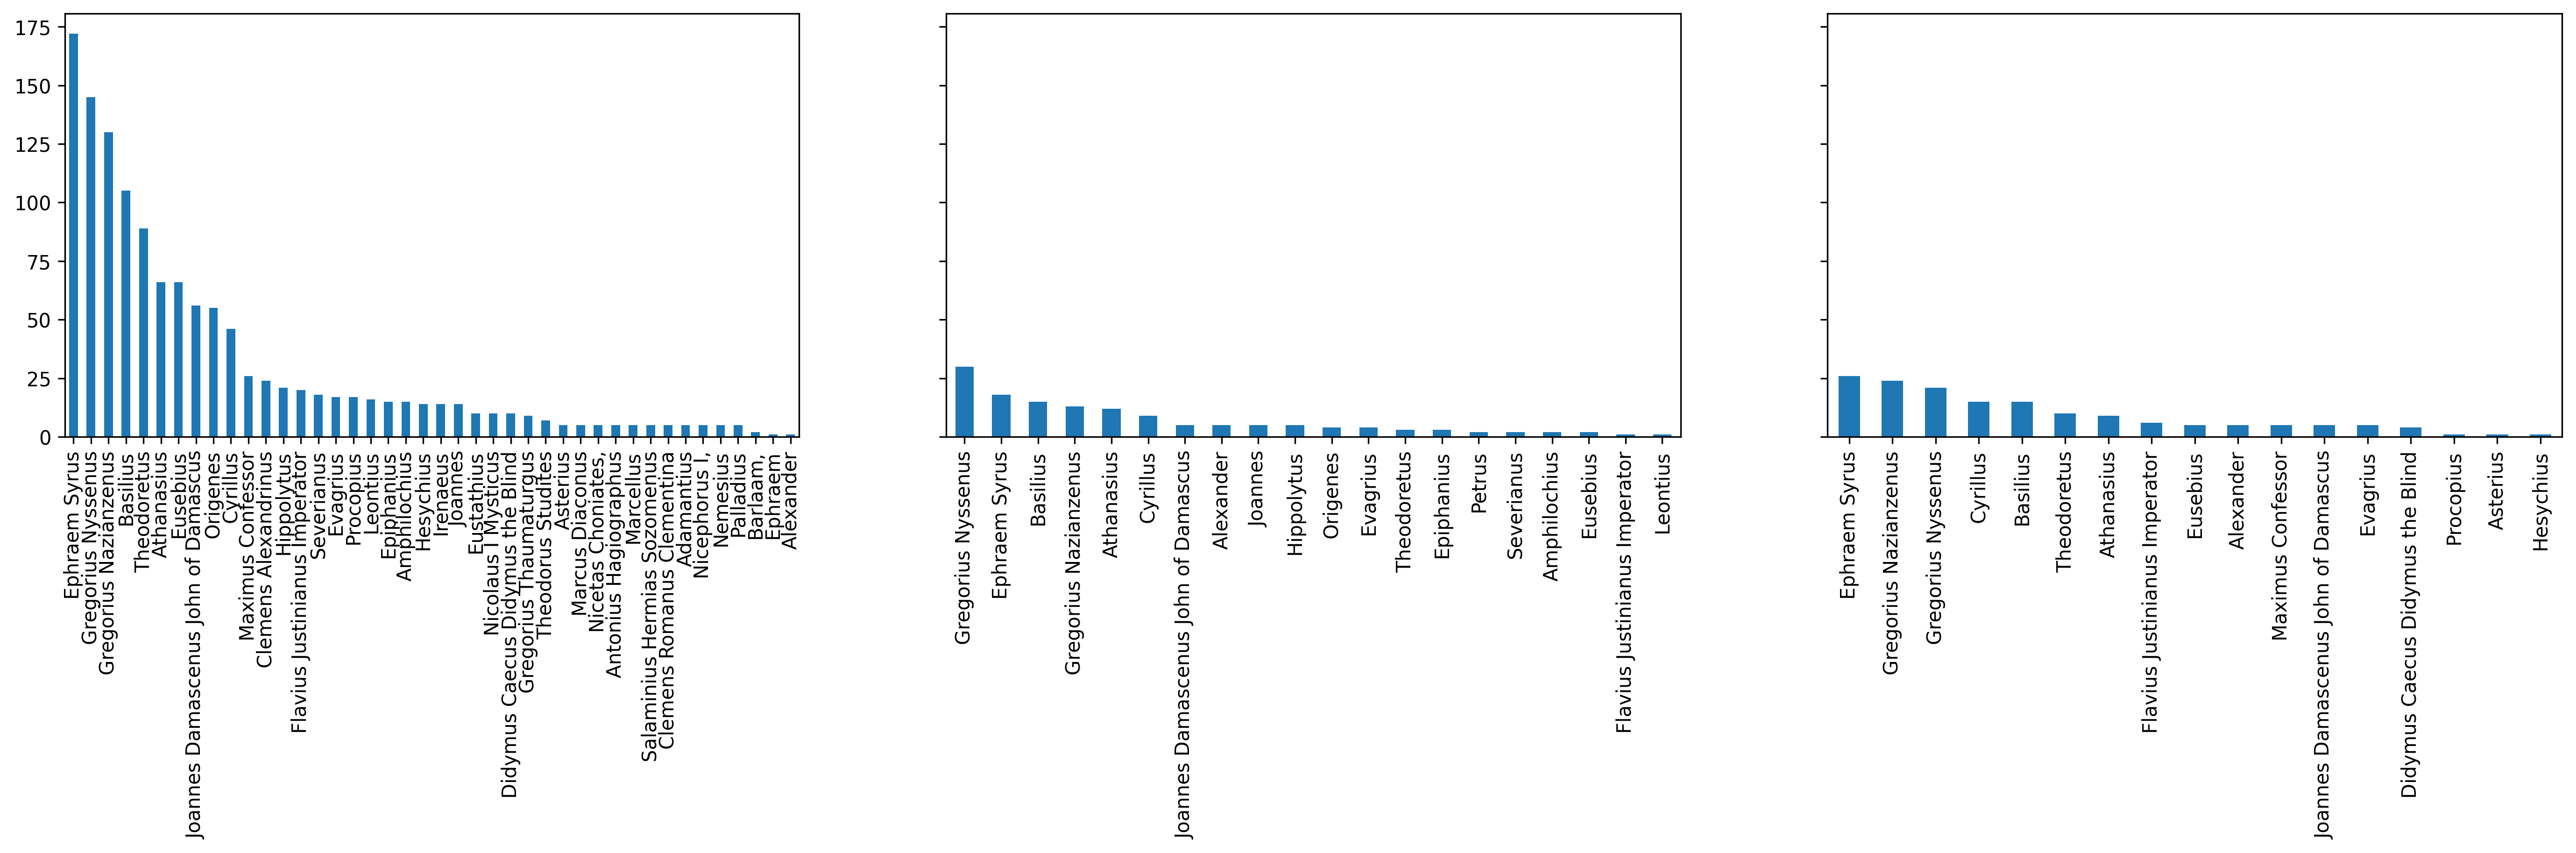

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300, figsize = (23, 4), sharey=True)
train.author.value_counts().plot.bar(ax=ax1)
dev.author.value_counts().plot.bar(ax=ax2)
test.author.value_counts().plot.bar(ax=ax3)
fig.savefig(make_file_name("samples.png"))

## Util functions

In [6]:
def assign_normalization(dfw):
    dfw.normalized._dataframe = dfw.dataframe.fillna(0)
    
def get_scores(scores, distance: float, col=METRICKEY, noprint=False) -> None:

    if "distance" in col.lower():
        scores["Attribution"] = scores[col] <= distance
    else:
        scores["Attribution"] = scores[col] >= distance
    
    pos = scores[scores.IsAPair].Attribution.value_counts().to_dict()
    negs = scores[~scores.IsAPair].Attribution.value_counts().to_dict()
    
    tp = pos.get(True, 0)
    fn = pos.get(False, 0)
    fp = negs.get(True, 0)
    tn = negs.get(False, 0)
    
    if noprint is False:
        print(f"True positives: {tp}\nFalse Negative {fn}")
        print(f"True Negative {tn}")
        print(f"False positives: {fp}\nAccuracy: {tp/(fn+tp):.2f}")
    return tp, fp, tn, fn

## Loading the model

In [7]:
models = SiameseFeatureModule.load_from_checkpoint("epoch=201-step=4040.ckpt") 

models.eval()

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


SiameseFeatureModule(
  (aucroc): AUROC()
  (distance): SNRDistance()
  (loss_func): SignalToNoiseRatioContrastiveLoss(
    (distance): SNRDistance()
    (reducer): MultipleReducers(
      (reducers): ModuleDict(
        (pos_loss): AvgNonZeroReducer()
        (neg_loss): AvgNonZeroReducer()
      )
      (default_reducer): MeanReducer()
    )
  )
  (miner): BatchEasyHardMiner(
    (distance): SNRDistance()
  )
  (encoder): Sequential(
    (0): BatchNorm1d(2100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2100, out_features=64, bias=True)
  )
)

## Automatically retrieve some constant parameters

In [8]:
FEATURES = models.hparams["features"]
IGNORE = set([col for col in train.columns if col not in FEATURES])

## Get DataFrameWrapper

In [9]:
data = DataframeWrapper(train, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data)
data.update_features(FEATURES)
data_dev = DataframeWrapper(dev, target="author", label=["author", "title"], x_ignore=IGNORE)
data_dev.update_features(data.features)
assign_normalization(data_dev)
data_test = DataframeWrapper(test, target="author", label=["author", "title"], x_ignore=IGNORE)
data_test.update_features(data.features)
assign_normalization(data_test)
data._x_ignore

('modified_text',
 'tokens',
 'length',
 'title',
 'textgroup',
 'Unnamed: 0',
 'file',
 'author')

## CHecking some details

In [10]:
data.normalized.xs.head()

$POS$v-n-v  $POS$v-c-d  $POS$d-l-n  $POS$l-n-n  $POS$d-n-v  $POS$n-v-l  \
0    0.001786    0.010714    0.012500    0.017857    0.010714    0.017857   
3    0.002519    0.005038    0.015113    0.015113    0.002519    0.022670   
5    0.007018    0.001754    0.010526    0.021053    0.001754    0.024561   
6    0.000000    0.003992    0.007984    0.021956    0.000000    0.017964   
7    0.005894    0.015717    0.013752    0.011788    0.005894    0.009823   

   $POS$l-l-n  $POS$n-n-v  $POS$n-v-n  $POS$n-v-r  ...  $TRI$σῶμ  $TRI$οἷο  \
0    0.008929    0.008929    0.003571    0.014286  ...  0.000268  0.000000   
3    0.005038    0.002519    0.007557    0.000000  ...  0.000000  0.000279   
5    0.001754    0.012281    0.001754    0.010526  ...  0.000279  0.000000   
6    0.009980    0.013972    0.003992    0.011976  ...  0.000000  0.000000   
7    0.007859    0.011788    0.005894    0.011788  ...  0.000000  0.000275   

   $TRI$λῳ_  $TRI$_ἤγ  $TRI$ἁπλ  $TRI$_λύ  $TRI$ἐνδ  $TRI$_λυ  $TRI$λεγ  \
0  0.000268  0.000000  0.000268  0.000268  0.000268  0.000000  0.000000   
3  0.000279  0.000000  0.000279  0.000000  0.000279  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000558  0.001116   
6  0.000000  0.000278  0.000000  0.000000  0.000000  0.000000  0.000555   
7  0.000000  0.000000  0.000000  0.000000  0.000275  0.000275  0.000824   

   $TRI$εἴρ  
0       0.0  
3       0.0  
5       0.0  
6       0.0  
7       0.0  

[5 rows x 2100 columns]

### Get first FP distance

In [11]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
scores = get_df_prediction(trainer, model=models, compared=data)
#scores
print(f"ROC: {roc_auc_score(scores.IsAPair, scores.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.938254496348442


In [12]:
scores[~scores.IsAPair].sort_values("Distance").head()

ComparedClass                         ComparedLabel ComparatorClass  \
20993       Origenes     Origenes - Homiliae in Ezechielem     Theodoretus   
821738   Theodoretus  Theodoretus - Historia ecclesiastica        Origenes   
20973       Origenes     Origenes - Homiliae in Ezechielem     Theodoretus   
901961   Theodoretus  Theodoretus - Historia ecclesiastica        Origenes   
980059   Theodoretus  Theodoretus - Historia ecclesiastica        Origenes   

                             ComparatorLabel  Distance  Probability  \
20993   Theodoretus - Historia ecclesiastica  0.320681     0.679319   
821738     Origenes - Homiliae in Ezechielem  0.334291     0.665709   
20973   Theodoretus - Historia ecclesiastica  0.365981     0.634019   
901961          Origenes - Homiliae in Lucam  0.392443     0.607557   
980059      Origenes - Homiliae in Leviticum  0.406744     0.593256   

        Attribution  IsAPair  K  
20993          True    False  0  
821738         True    False  0  
20973          True    False  0  
901961         True    False  0  
980059         True    False  0

## Evaluating Dev for Test Threshold

In [13]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
dev_pairs = get_df_prediction(trainer, model=models, compared=data_dev)
#scores
print(f"ROC: {roc_auc_score(dev_pairs.IsAPair, dev_pairs.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.8016291906191179


In [14]:
dev_pairs[~dev_pairs.IsAPair].sort_values("Distance").head()

ComparedClass                                      ComparedLabel  \
2905   Gregorius Nyssenus  Gregorius Nyssenus - Refutatio confessionis Eu...   
10168  Gregorius Nyssenus  Gregorius Nyssenus - Refutatio confessionis Eu...   
5941        Ephraem Syrus                    Ephraem Syrus - Sermo asceticus   
10305  Gregorius Nyssenus  Gregorius Nyssenus - Refutatio confessionis Eu...   
3473             Eusebius      Eusebius - Quaestiones evangelicae ad Marinum   

      ComparatorClass                           ComparatorLabel  Distance  \
2905         Leontius  Leontius - In sanctum pascha (homilia 8)  0.596639   
10168        Basilius                 Basilius - De virginitate  0.602830   
5941         Evagrius     Evagrius - Rerum monachalium rationes  0.614185   
10305        Basilius                 Basilius - De virginitate  0.616184   
3473       Athanasius  Athanasius - De decretis Nicaenae synodi  0.633528   

       Probability  Attribution  IsAPair  K  
2905      0.403361        False    False  0  
10168     0.397170        False    False  0  
5941      0.385815        False    False  0  
10305     0.383816        False    False  0  
3473      0.366472        False    False  0

<AxesSubplot:>

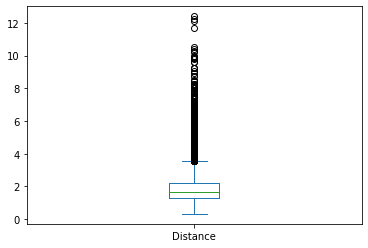

In [15]:
dev_pairs.Distance.plot.box()

In [16]:
#clip = scores.Distance.apply(lambda x: 2 if x > 2 else x)
#scores.Distance = clip

## Study AUCROC

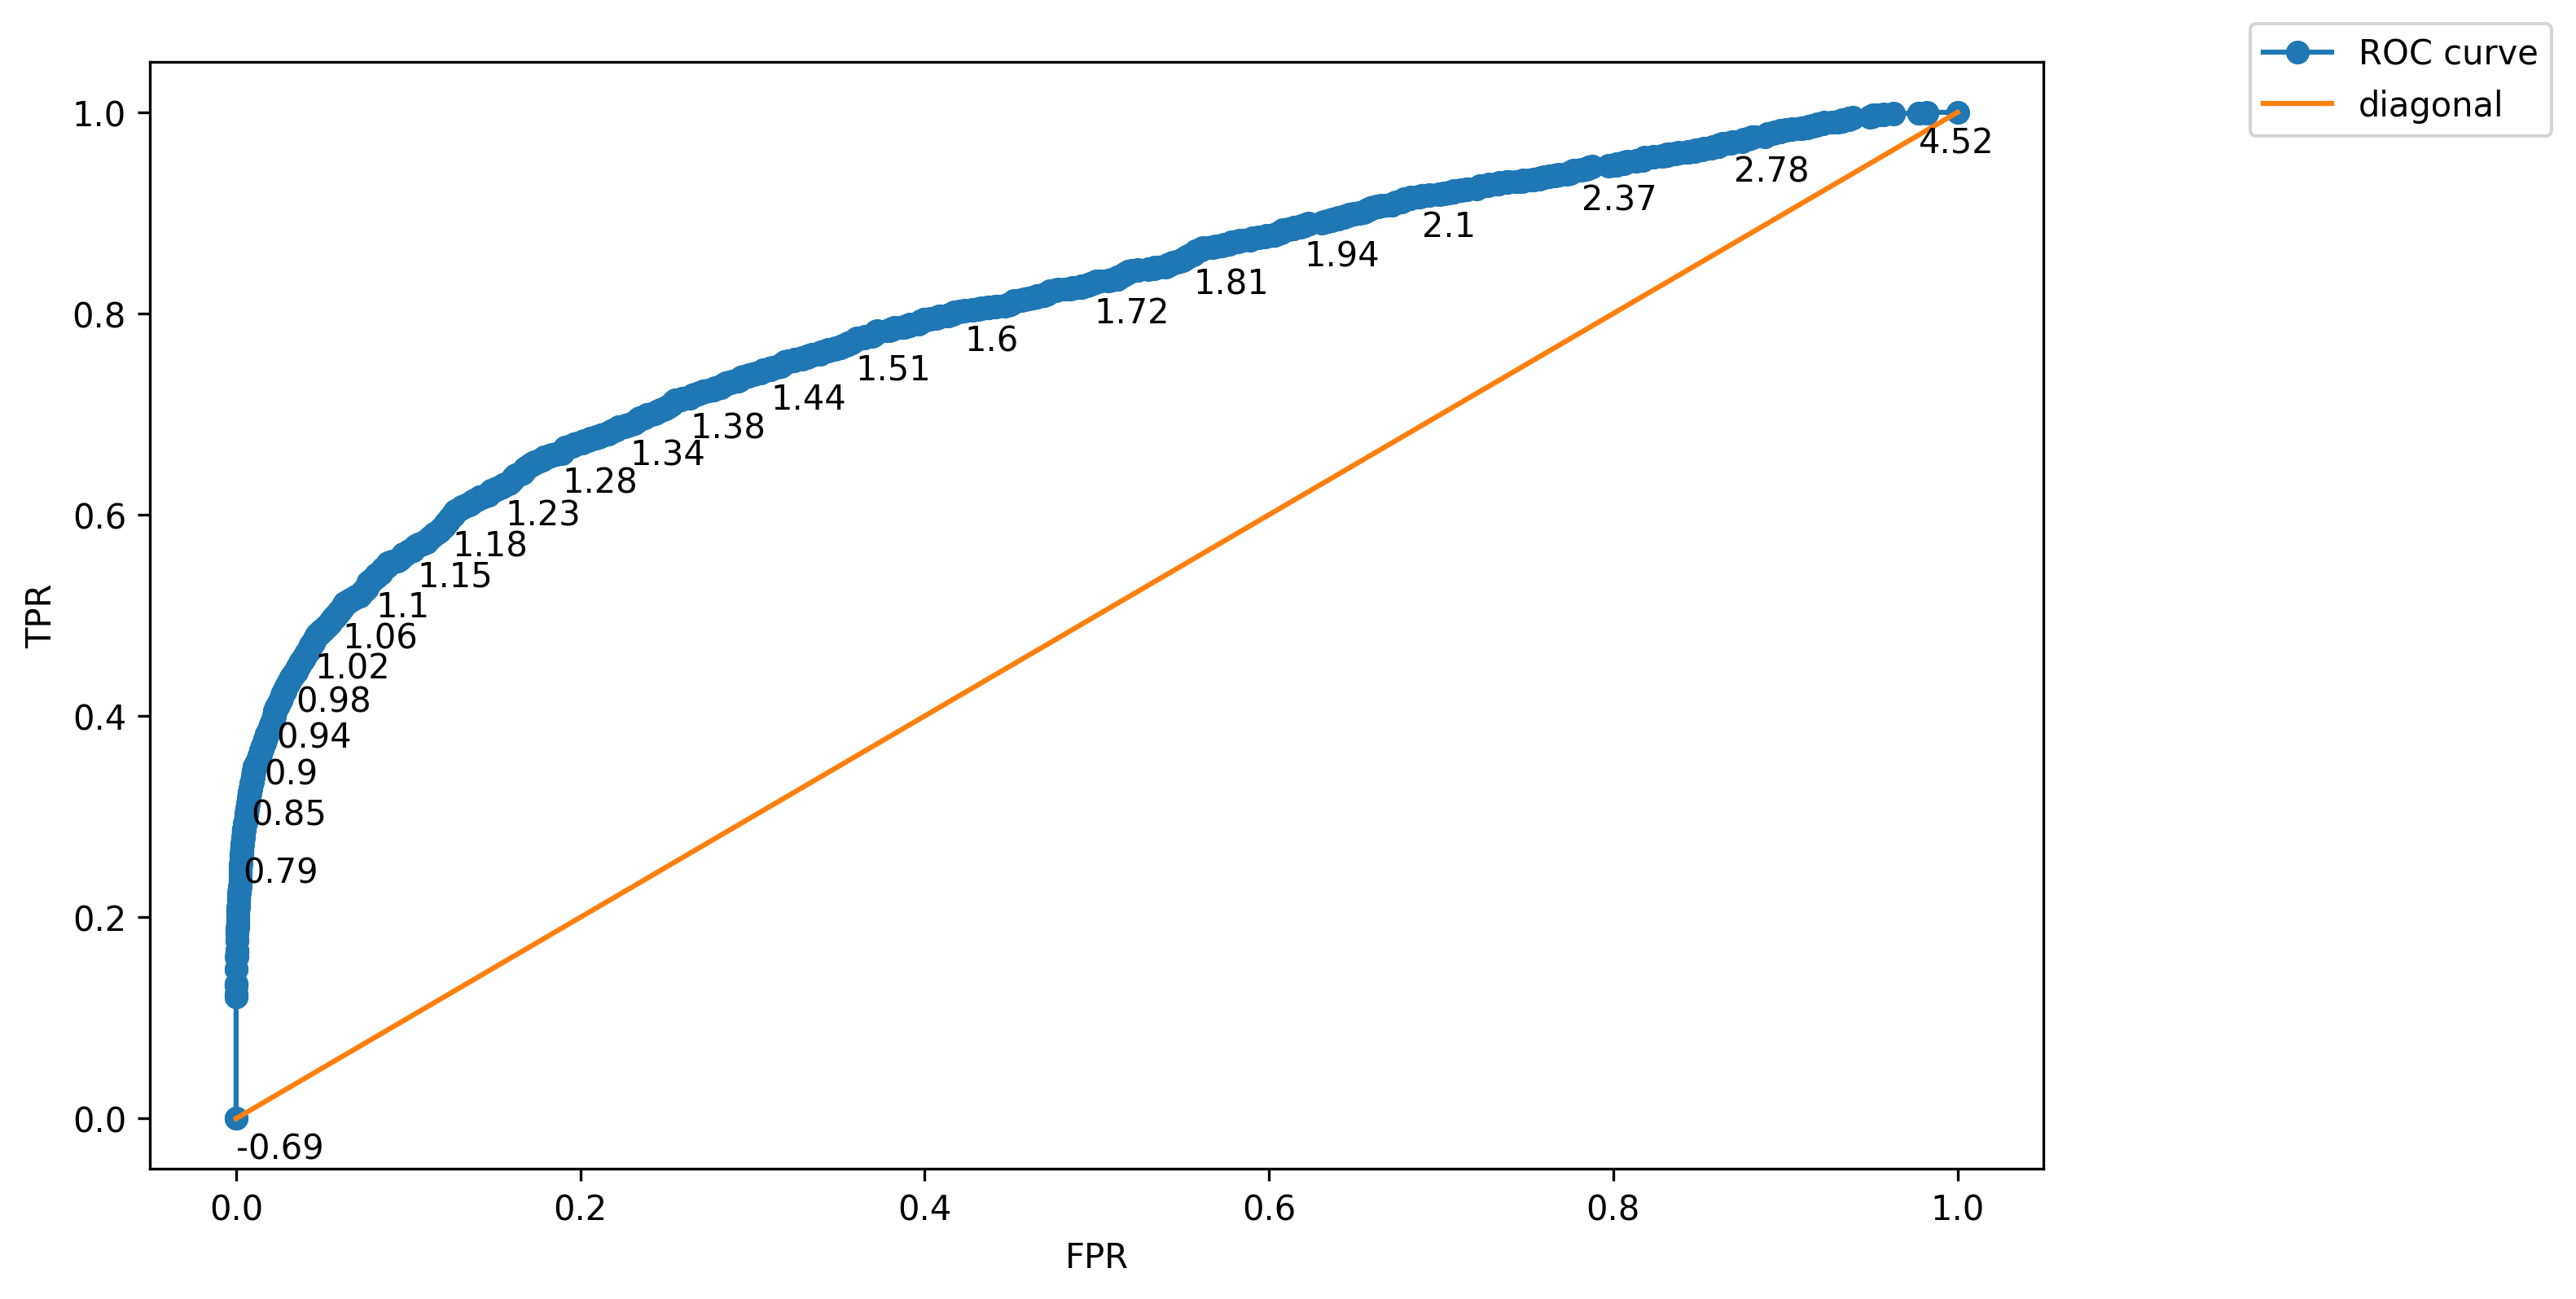

In [17]:
plot_aucroc_curve(dev_pairs.IsAPair, dev_pairs[METRICKEY], nth=100, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("aucroc-dev.png"))

In [18]:
# for cls in dev_pairs.ComparedClass.unique():
#     plt.figure()
#     sns.boxplot(data=dev_pairs[(dev_pairs.ComparedClass==cls)], x="IsAPair", y=METRICKEY)
#     plt.gca().set_title(cls)
#     plt.gcf().savefig(make_file_name(f"Dev-{cls}.png"))
    #scores.groupby("ComparedClass").plot.box(y="Distance", x="IsAPair")

### Find sweet spot

In [19]:
MAX_DISTANCE = 6
get_scores(dev_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(dev_pairs[(dev_pairs.ComparedLabel != dev_pairs.ComparatorLabel)], MAX_DISTANCE)

True positives: 1870
False Negative 0
True Negative 133
False positives: 17737
Accuracy: 1.00

===
Without sampling
===

True positives: 1474
False Negative 0
True Negative 133
False positives: 17737
Accuracy: 1.00


/tmp/ipykernel_29217/4096291782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(1474, 17737, 133, 0)

## Evaluating Test with Dev Threshold

In [20]:
models.eval()
MAX_DISTANCE = 6

test_pairs = get_df_prediction(trainer, model=models, compared=data_test, threshold=MAX_DISTANCE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [21]:
test_pairs[~test_pairs.IsAPair].sort_values(METRICKEY).head()

ComparedClass  \
9520                Basilius   
8621      Gregorius Nyssenus   
21923  Gregorius Nazianzenus   
9166   Gregorius Nazianzenus   
9323   Gregorius Nazianzenus   

                                           ComparedLabel  \
9520             Basilius - De legendis gentilium libris   
8621     Gregorius Nyssenus - In inscriptiones Psalmorum   
21923  Gregorius Nazianzenus - In sancta lumina (orat...   
9166   Gregorius Nazianzenus - Funebris in laudem Cae...   
9323   Gregorius Nazianzenus - Funebris oratio in pat...   

             ComparatorClass  \
9520   Gregorius Nazianzenus   
8621               Alexander   
21923               Basilius   
9166                Basilius   
9323                Basilius   

                                         ComparatorLabel  Distance  \
9520   Gregorius Nazianzenus - In sancta lumina (orat...  0.485413   
8621      Alexander - Tractatus de placitis Manichaeorum  0.494567   
21923            Basilius - De legendis gentilium libris  0.539050   
9166             Basilius - De legendis gentilium libris  0.569751   
9323             Basilius - De legendis gentilium libris  0.575747   

       Probability  Attribution  IsAPair  K  
9520      0.514587         True    False  0  
8621      0.505433         True    False  0  
21923     0.460950         True    False  0  
9166      0.430249         True    False  0  
9323      0.424253         True    False  0

In [22]:
print(f"ROC: {roc_auc_score(test_pairs.IsAPair, test_pairs.Probability)}")
MAX_DISTANCE = 6
get_scores(test_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(test_pairs[(test_pairs.ComparedLabel != test_pairs.ComparatorLabel)], MAX_DISTANCE)

ROC: 0.8551206217513526
True positives: 2346
False Negative 0
True Negative 68
False positives: 22392
Accuracy: 1.00

===
Without sampling
===

True positives: 1816
False Negative 0
True Negative 68
False positives: 22392
Accuracy: 1.00


/tmp/ipykernel_29217/4096291782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(1816, 22392, 68, 0)

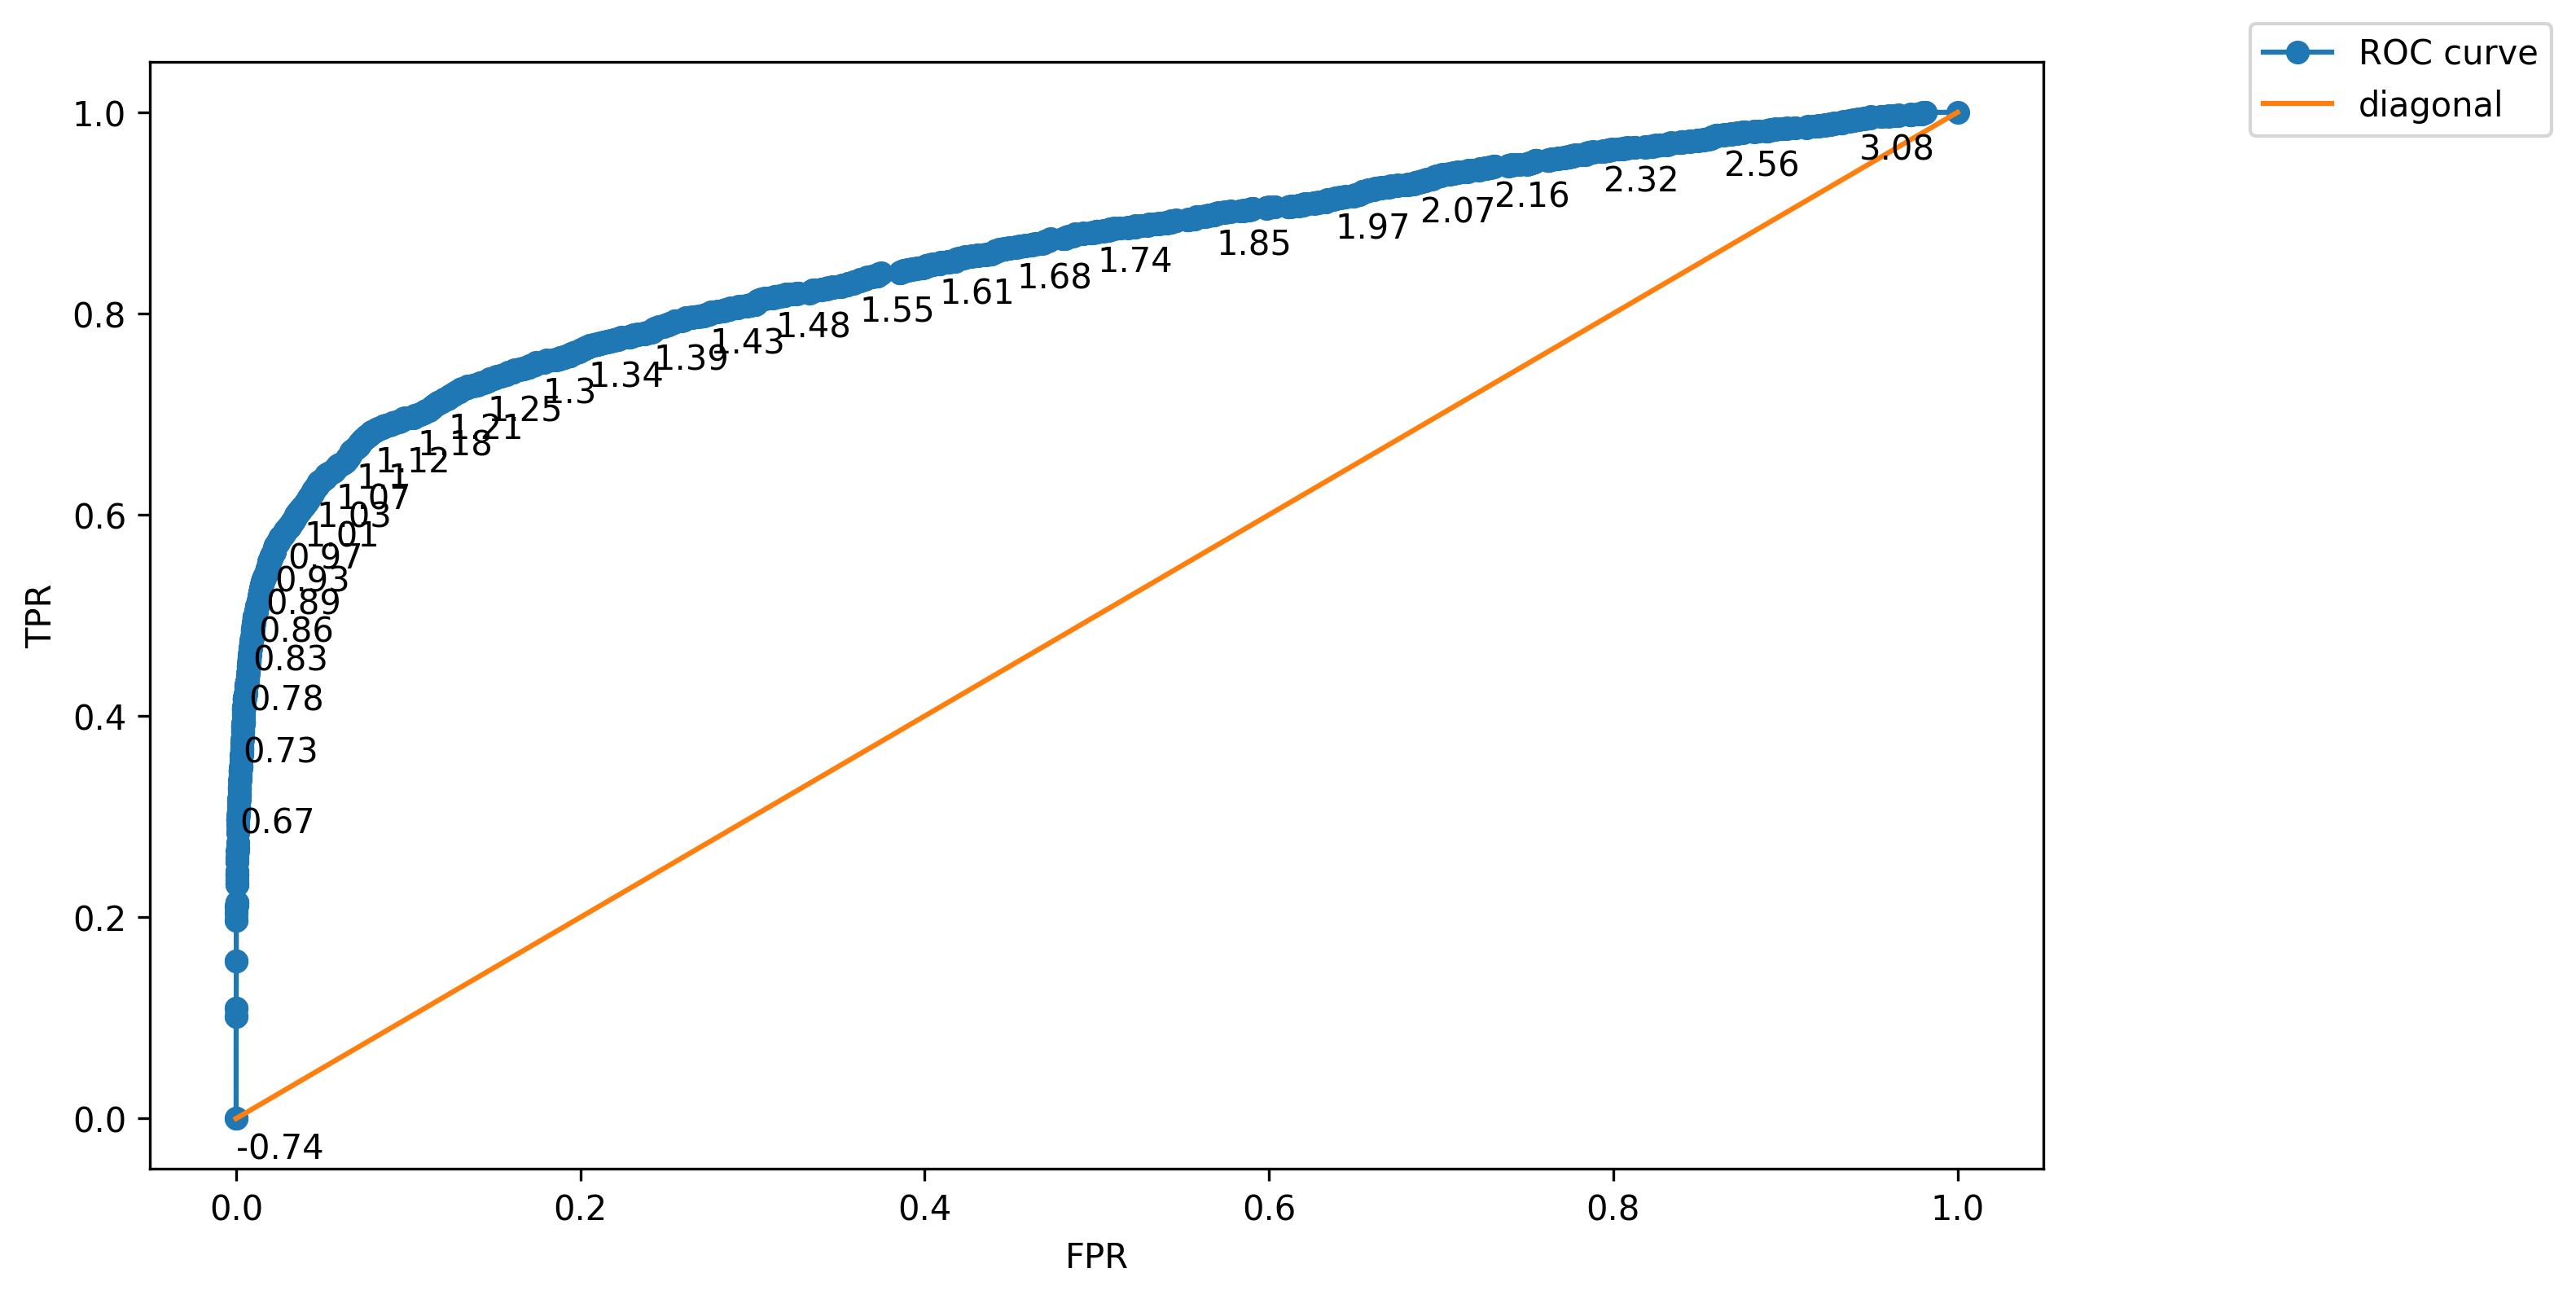

In [23]:
plot_aucroc_curve(test_pairs.IsAPair, test_pairs[METRICKEY], nth=75, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("test-aucroc.png"))

In [24]:
test_pairs.to_csv(make_file_name("test-results.csv"))

## On Voicu !

In [25]:
import regex as re
import json
import unicodedata

df = pd.read_csv("pc-features.csv")
DFW = DataframeWrapper(df, label=("author", "title"), target="title", 
                       x_ignore=[col for col in df.columns if col not in data.features])
#
print(len(DFW.features))
print(len(data.features))
DFW.update_features(data.features)
assign_normalization(DFW)
#DFW._features = data.features
print(len(data.features))
print(len(DFW.features))

2059
2100
2100 new features found, setting them as 0.
2100
2100


In [26]:
models.eval()
pairs = get_df_prediction(
    trainer, model=models, 
    compared=DFW,
    threshold=MAX_DISTANCE
)
pairs = pairs[pairs.ComparedLabel != pairs.ComparatorLabel]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [27]:
pairs["ComparedClass"] = pairs.ComparedLabel.apply(lambda x: x.split()[0].strip())
pairs["ComparatorClass"] = pairs.ComparatorLabel.apply(lambda x: x.split()[0].strip())
pairs["IsAPair"] = pairs.ComparedClass == pairs.ComparatorClass
pairs.head()

ComparedClass                               ComparedLabel ComparatorClass  \
0          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum            PC13   
1          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum             PCX   
2          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum             PC6   
3          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum            PC16   
4          PC20  PC20 - InIlludCredidiPropterQuodLocutusSum             PC8   

                           ComparatorLabel  Distance  Probability  \
0               PC13 - InVenerabilemCrucem  1.605479    -0.605479   
1                   PCX - DeJenunioSermo5B  2.913513    -1.913513   
2               PC6 - DePoenintentiaSermo1  1.287527    -0.287527   
3  PC16 - InIlludSiQuaChristoaNovaCreatura  1.388698    -0.388698   
4                  PC8 - DePatientiaSermo1  1.155616    -0.155616   

   Attribution  IsAPair  K  
0         True    False  0  
1         True    False  0  
2         True    False  0  
3         True    False  0  
4         True    False  0

In [28]:
pairs[f"Rounded{METRICKEY}"] = pairs[METRICKEY].round(3)
dists = sorted(pairs[f"Rounded{METRICKEY}"].unique())

pairs["TestTPR"] = .0
pairs["TestPre"] = .0
pairs["TestFPR"] = 1.0
pairs["TestFP"] = -1
pairs["TestFN"] = -1
pairs["TestTP"] = -1
pairs["TestTN"] = -1
pairs["DevTPR"] = .0
pairs["DevPre"] = .0
pairs["DevFPR"] = 1.0
pairs["DevFP"] = -1
pairs["DevFN"] = -1
pairs["DevTP"] = -1
pairs["DevTN"] = -1

for dist in dists:
    tp, fp, tn, fn = get_scores(test_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "TestTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "TestFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "TestPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "TestFP"] = fp
    pairs.loc[filt, "TestTP"] = tp
    pairs.loc[filt, "TestFN"] = fn
    pairs.loc[filt, "TestTN"] = tn
    
    # DEV
    
    tp, fp, tn, fn = get_scores(dev_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "DevTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "DevFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "DevPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "DevFP"] = fp
    pairs.loc[filt, "DevTP"] = tp
    pairs.loc[filt, "DevFN"] = fn
    pairs.loc[filt, "DevTN"] = tn
    

In [29]:
pairs.sort_values("DevPre").tail()

ComparedClass               ComparedLabel ComparatorClass  \
1413           PC5       PC5 - ContraHereticos             PC9   
4491          PC21       PC21 - InJobSermones3            PC16   
3828           PC9         PC9 - InCenturionem             PC5   
3795           PC7        PC7 - DeIeiunoSermo1             PC5   
2720          PC16  PC16 - InPsalmum50Homilia2            PC16   

                              ComparatorLabel  Distance  Probability  \
1413                      PC9 - InCenturionem  0.502351     0.497649   
4491      PC16 - InIlludSufficitTibiGratiaMea  0.353777     0.646223   
3828                    PC5 - ContraHereticos  0.581038     0.418962   
3795                    PC5 - ContraHereticos  0.559714     0.440286   
2720  PC16 - InIlludSiQuaChristoaNovaCreatura  0.392623     0.607377   

      Attribution  IsAPair  K  RoundedDistance  ...  TestFN  TestTP  TestTN  \
1413         True    False  0            0.502  ...    2073     273   22458   
4491         True    False  0            0.354  ...    2318      28   22460   
3828         True    False  0            0.581  ...    1854     492   22455   
3795         True    False  0            0.560  ...    1910     436   22457   
2720         True     True  0            0.393  ...    2280      66   22460   

        DevTPR  DevPre  DevFPR  DevFP  DevFN  DevTP  DevTN  
1413  0.056150     1.0     0.0      0   1765    105  17870  
4491  0.003743     1.0     0.0      0   1863      7  17870  
3828  0.110160     1.0     0.0      0   1664    206  17870  
3795  0.093048     1.0     0.0      0   1696    174  17870  
2720  0.009626     1.0     0.0      0   1852     18  17870  

[5 rows x 24 columns]

In [30]:
pairs.sort_values(["DevPre", "TestPre", "Distance"]).to_csv(make_file_name("pairs-last-experiment.csv"))

## Visualize dev

In [31]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)

# We first get the wonderful classes of compared
dev_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_dev, model=models, batch_size=8))
)
dev_vectors = torch.cat([vec.cpu() for vec in dev_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_dev.get_labels(), data_dev.ys.tolist(), dev_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))
    
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [32]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("dev.html"))

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/uma

## Test

In [33]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
# We first get the wonderful classes of compared
test_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_test, model=models, batch_size=8))
)
test_vectors = torch.cat([vec.cpu() for vec in test_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_test.get_labels(), data_test.ys.tolist(), test_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [34]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("test.html"))

## PCs

In [35]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
# We first get the wonderful classes of compared
pcs, _ = zip(
    *trainer.predict(models, make_dataloader(DFW, model=models, batch_size=8))
)
pcs = torch.cat([vec.cpu() for vec in pcs], dim=0)


dataframe = []

for label, vector in zip(DFW.get_labels(), pcs.tolist()):
    author, label = label.split(" - ")
    dataframe.append((author, label, *vector))
    
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])
df

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

Author                                       Title      Dim0      Dim1  \
0    PC20         InIlludCredidiPropterQuodLocutusSum  0.161530 -0.241516   
1    PC13                         InVenerabilemCrucem -0.138460  0.134179   
2     PCX                            DeJenunioSermo5B  0.000418  0.131150   
3     PC6                        DePoenintentiaSermo1  0.118161  0.356870   
4    PC16            InIlludSiQuaChristoaNovaCreatura  0.048310  0.097004   
..    ...                                         ...       ...       ...   
65  PC20b  InIlludSimileEstRegnumCaelorumGranoSinapis -0.123554  0.021699   
66   PC10                               DePrecatione1 -0.209161  0.290497   
67    PC3                                InMeretricem  0.191858  0.415573   
68    PC4                           InPaschaSermones6 -0.144156  0.000624   
69    PC6                        DePoenintentiaSermo2 -0.062303  0.351617   

        Dim2      Dim3      Dim4      Dim5      Dim6      Dim7  ...     Dim54  \
0   0.045298 -0.067115 -0.062065 -0.083104  0.041564  0.226876  ... -0.208867   
1   0.073435 -0.002178 -0.066891  0.052947  0.363598 -0.007284  ... -0.133403   
2  -0.273970  0.216991 -0.272473 -0.042538  0.808539  0.399606  ...  0.114189   
3  -0.063163 -0.096852 -0.180592  0.126981  0.187724  0.483374  ... -0.191276   
4   0.103596  0.048219  0.100290  0.273725  0.087429  0.435890  ... -0.218906   
..       ...       ...       ...       ...       ...       ...  ...       ...   
65 -0.063756 -0.359948 -0.234319 -0.518873 -0.209615  0.245665  ...  0.232747   
66 -0.012988  0.462587 -0.098887  0.232545 -0.091808  0.237602  ... -0.149003   
67  0.099556 -0.521016 -0.418093  0.063105 -0.173671  0.320170  ... -0.048930   
68 -0.052625 -0.231795 -0.159570 -0.041819 -0.110521  0.223527  ...  0.084619   
69 -0.559844  0.066156 -0.184302 -0.319531  0.521051  0.654999  ... -0.142350   

       Dim55     Dim56     Dim57     Dim58     Dim59     Dim60     Dim61  \
0   0.135758  0.128895  0.133323 -0.128039  0.049698  0.257831 -0.234773   
1   0.053627  0.088196  0.054196 -0.302332  0.037884 -0.244791 -0.102549   
2   0.572649  0.016387  0.132754  0.169029  0.150429  0.074823 -0.417798   
3   0.440802  0.057764 -0.087305 -0.191783  0.176371  0.243174 -0.094866   
4   0.347954 -0.132829  0.145113 -0.153805  0.309501  0.206957  0.198470   
..       ...       ...       ...       ...       ...       ...       ...   
65  0.458610  0.192253  0.003262  0.042922  0.157756 -0.036713 -0.101316   
66  0.455373 -0.091621 -0.288910 -0.023026 -0.151939  0.405967 -0.315555   
67  0.280382  0.099266  0.444253 -0.022455  0.044145  0.315030 -0.273308   
68  0.306633 -0.176367  0.068679  0.062898  0.070570  0.025237 -0.354376   
69  0.300116  0.152796 -0.219853 -0.199225  0.503912  0.288301  0.074297   

       Dim62     Dim63  
0  -0.101320  0.020577  
1   0.060290 -0.128909  
2  -0.538458  0.170173  
3  -0.189457  0.118329  
4  -0.031524  0.049358  
..       ...       ...  
65 -0.044753 -0.305518  
66  0.141805 -0.380866  
67  0.255681 -0.390788  
68  0.006755 -0.062138  
69 -0.371283  0.277474  

[70 rows x 66 columns]

In [36]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("pc.html"))